In [ ]:



# url = "https://fastapi.tiangolo.com/python-types/"

# response = requests.get(url)

# soup = BeautifulSoup(response.text, "html.parser")


In [ ]:
# all_specific_divs = soup.find_all("div", class_="tabbed-set tabbed-alternate")
# codes = []
# if all_specific_divs:
#     print("\nFound div content using find_all():")
#     for i ,div in enumerate(all_specific_divs):
#         code = div.get_text()
#         codes.append(code)
# else:
#     print("No divs found.")

NameError: name 'c' is not defined

In [ ]:
#main_div = soup.find("div", class_ = 'md-content')



In [2]:
import json
import requests
from bs4 import BeautifulSoup, Tag

def scrape_page(url):

    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")
    main_div = soup.find("div", class_ = 'md-content')

    page_content = {
    "url" : None,
    "title" : None,
    "content" : []
    }
    
    page_content['url'] = url

    for children in main_div.descendants:


        # skipping note blocks 
        if children.find_parent("div",class_=["admonition", "note", "info", "tip"]):
            continue
        # skipping navigable block at the start of the page
        if children.find_parent('nav', class_ = "md-path"):
            continue

        # extracting title
        if children.name == "h1":
            page_content["title"] = children.get_text(strip = True)[:-1]
            page_content["content"].append({
                'type' : 'heading',
                'level' : 1,
                'text' : page_content['title']

            })
            continue
        #extracting subheadings
        if children.name in ['h2', 'h3', 'h4', 'h5', 'h6']:
            page_content['content'].append({
                'type' : 'heading',
                'level' : int(children.name[1]),
                'text' : children.get_text(strip = True)[:-1]

            })
            continue
        # extracting paragraphs
        if children.name == "p":
            text = children.get_text(" ", strip=True)
            if text:
                page_content["content"].append({
                    "type": "text",
                    "text": text
                })
            continue
        # extracting bullet points
        if children.name in ["ul", "ol"]:
            for li in children.find_all("li", recursive=False):
                text = li.get_text(" ", strip=True)
                if text:
                    page_content["content"].append({
                        "type": "list_item",
                        "text": text
                    })
            continue

        #extracting code blocks, keeping the structure as it is
        if isinstance(children, Tag) and "tabbed-content" in children.get("class", []):
            page_content["content"].append({
                'type' : 'code',
                'text' : children.get_text(strip=False)[2:-3]

            })
            continue
        
        
        if isinstance(children, Tag) and "highlight" in children.get("class", []) and not children.find_parent('div', class_ ="tabbed-content"):
            page_content["content"].append({
                'type' : 'code',
                'text' : children.get_text(strip=False)

            })
            continue
            

        continue
    return page_content

    



    

In [31]:
import json

with open(r'C:\Users\amanm\Desktop\learning\rag_project\url.json', 'r') as file:
   urls =  json.load(file)

In [30]:
from urllib.parse import urljoin

base_url = 'https://fastapi.tiangolo.com/'
all_pages = []
for rel_url in urls:
    url = urljoin(base_url, rel_url)
    page_cont = scrape_page(url)
    all_pages.append(page_cont)

    with open('scraped_data_page_wise.json', 'w') as json_file:
        json.dump(all_pages, json_file, indent=4)
    



NameError: name 'scrape_page' is not defined

## Scraping Pipeline, for all pages

In [32]:
import json
from urllib.parse import urljoin
from scraping.scraping_pipeline import scrape_all_pages


In [33]:
## link loading

BASE_URL = 'https://fastapi.tiangolo.com/'

with open("url.json", "r") as urls:
    all_url = json.load(urls)


scrape_all_pages(BASE_URL, all_url)

## Chunking Implementations 

In [34]:
import json
with open("document.json", 'r') as f:
    docs = json.load(f)

In [138]:
docs[0]

{'url': 'https://fastapi.tiangolo.com/python-types/',
 'title': 'Python Types Intro',
 'content': [{'type': 'heading', 'level': 1, 'text': 'Python Types Intro'},
  {'type': 'text',
   'text': 'Python has support for optional "type hints" (also called "type annotations").'},
  {'type': 'text',
   'text': 'These "type hints" or annotations are a special syntax that allow declaring the type of a variable.'},
  {'type': 'text',
   'text': 'By declaring types for your variables, editors and tools can give you better support.'},
  {'type': 'text',
   'text': 'This is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.'},
  {'type': 'text',
   'text': 'FastAPI is all based on these type hints, they give it many advantages and benefits.'},
  {'type': 'text',
   'text': 'But even if you never use FastAPI , you would benefit from learning a bit about them.'},
  {'type': 'heading', 'level': 2, 

In [141]:
def prepare_for_structure(doc_page):
    d = []
    section_path = []
    temp_d= {}
    for section in doc_page['content']:
        if len(section) == 3:

            if temp_d:
                temp_d['section_path'] = " -> ".join(temp_d['section_path'])
                d.append(temp_d)

            temp_d= {}
            section_path.append(section['text'])
            #temp_d['section_path'] =  section_path.copy()
            temp_d = {
                'section_path' : section_path.copy(),
                'blocks' : [],
                'path' : section_path.copy(),
                'url' : doc_page['url']
            }
        
        else:
            if section['type'] == 'text':
                if 'blocks' not in temp_d:
                    temp_d['blocks'] = [section['text']]
                else:
                    temp_d['blocks'].append(section['text']) 
            elif section['type'] == 'code':
                if 'blocks' not in temp_d:
                    temp_d['blocks'] = [section['text']]
                else:
                    temp_d['blocks'].append(section['text'])
            elif section['type'] == "list_item":
                if 'blocks' not in temp_d:
                    temp_d['blocks'] = ["-" + section['text']]
                else:
                    temp_d['blocks'].append('-' + section['text'])

    if temp_d:
        temp_d['section_path'] = " -> ".join(temp_d['section_path'])
        d.append(temp_d)

    return d

In [144]:
prepare_for_structure(docs[98])

[{'section_path': 'Extending OpenAPI',
  'blocks': ['There are some cases where you might need to modify the generated OpenAPI schema.',
   'In this section you will see how.'],
  'path': ['Extending OpenAPI'],
  'url': 'https://fastapi.tiangolo.com/how-to/extending-openapi/'},
 {'section_path': 'Extending OpenAPI -> The normal process',
  'blocks': ['The normal (default) process, is as follows.',
   'A FastAPI application (instance) has an .openapi() method that is expected to return the OpenAPI schema.',
   'As part of the application object creation, a path operation for /openapi.json (or for whatever you set your openapi_url ) is registered.',
   "It just returns a JSON response with the result of the application's .openapi() method.",
   'By default, what the method .openapi() does is check the property .openapi_schema to see if it has contents and return them.',
   "If it doesn't, it generates them using the utility function at fastapi.openapi.utils.get_openapi .",
   'And that f

## Data Preprocessing

In [12]:
import re
import emoji

text = "Hello world! 😊🌍 This is a test. 👨‍👩‍👧‍👦👍🏿"
no_emoji_text = emoji.replace_emoji(text, replace="").split()
print(" ".join(no_emoji_text))

Hello world! This is a test.


### S1. Writing a function to convert the doc.json into section wise chunk. (Done)
### S2. Data Preproceesing - Emoji Removal, code section should be visible greatly (Done)

In [145]:
# S1

def section_wise_split(docs):
    pages = []
    i = 0
    len_docs = len(docs)
    while i < len_docs:
       result_per_page = prepare_for_structure(docs[i])
       if len(pages) == 0:
           pages = result_per_page.copy()
       pages.extend(result_per_page)
       i += 1
    return pages
       
        
        
        

In [146]:
all_pages_section_wise_split = section_wise_split(docs)

In [147]:
all_pages_section_wise_split[1]

{'section_path': 'Python Types Intro -> Motivation',
 'blocks': ["Let's start with a simple example:",
  'CODE\ndef get_full_name(first_name, last_name):\n    full_name = first_name.title() + " " + last_name.title()\n    return full_name\n\nprint(get_full_name("john", "doe"))\n/CODE',
  'Calling this program outputs:',
  'John Doe\n',
  'The function does the following:',
  '-Takes a first_name and last_name .',
  '-Converts the first letter of each one to upper case with title() .',
  '-Concatenates them with a space in the middle.',
  'CODE\ndef get_full_name(first_name, last_name):\n    full_name = first_name.title() + " " + last_name.title()\n    return full_name\n\nprint(get_full_name("john", "doe"))\n/CODE'],
 'path': ['Python Types Intro', 'Motivation'],
 'url': 'https://fastapi.tiangolo.com/python-types/'}

In [148]:
# emoji remove

import emoji
l1 = prepare_for_structure(docs[0]).copy()
for section in l1:
    for i in range(len(section['blocks'])):
        section['blocks'][i] = emoji.replace_emoji(section['blocks'][i], replace=" ")

            



In [149]:
all_pages_section_wise_split

[{'section_path': 'Python Types Intro',
  'blocks': ['Python has support for optional "type hints" (also called "type annotations").',
   'These "type hints" or annotations are a special syntax that allow declaring the type of a variable.',
   'By declaring types for your variables, editors and tools can give you better support.',
   'This is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.',
   'FastAPI is all based on these type hints, they give it many advantages and benefits.',
   'But even if you never use FastAPI , you would benefit from learning a bit about them.'],
  'path': ['Python Types Intro'],
  'url': 'https://fastapi.tiangolo.com/python-types/'},
 {'section_path': 'Python Types Intro -> Motivation',
  'blocks': ["Let's start with a simple example:",
   'CODE\ndef get_full_name(first_name, last_name):\n    full_name = first_name.title() + " " + last_name.title()\n   

In [150]:
def remove_emoji(docs_list):
    len_all_docs = len(docs_list)
    for each_elmnt in docs_list:
        for i in range(len(each_elmnt['blocks'])):
            each_elmnt['blocks'][i] = emoji.replace_emoji(each_elmnt['blocks'][i], replace=" ")
    return docs_list

    

In [151]:
emoji_removed_data = remove_emoji(all_pages_section_wise_split)

In [152]:
emoji_removed_data

[{'section_path': 'Python Types Intro',
  'blocks': ['Python has support for optional "type hints" (also called "type annotations").',
   'These "type hints" or annotations are a special syntax that allow declaring the type of a variable.',
   'By declaring types for your variables, editors and tools can give you better support.',
   'This is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.',
   'FastAPI is all based on these type hints, they give it many advantages and benefits.',
   'But even if you never use FastAPI , you would benefit from learning a bit about them.'],
  'path': ['Python Types Intro'],
  'url': 'https://fastapi.tiangolo.com/python-types/'},
 {'section_path': 'Python Types Intro -> Motivation',
  'blocks': ["Let's start with a simple example:",
   'CODE\ndef get_full_name(first_name, last_name):\n    full_name = first_name.title() + " " + last_name.title()\n   

In [153]:
len_of_each_section = []
for section in emoji_removed_data:
    len_of_each_section.append(len(section['blocks']))

In [154]:
len_of_each_section[0]

6

In [155]:
emoji_removed_data[0]['blocks']

['Python has support for optional "type hints" (also called "type annotations").',
 'These "type hints" or annotations are a special syntax that allow declaring the type of a variable.',
 'By declaring types for your variables, editors and tools can give you better support.',
 'This is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.',
 'FastAPI is all based on these type hints, they give it many advantages and benefits.',
 'But even if you never use FastAPI , you would benefit from learning a bit about them.']

In [74]:
import pandas as pd

In [75]:
df = pd.DataFrame(len_of_each_section)

array([[<Axes: title={'center': '0'}>]], dtype=object)

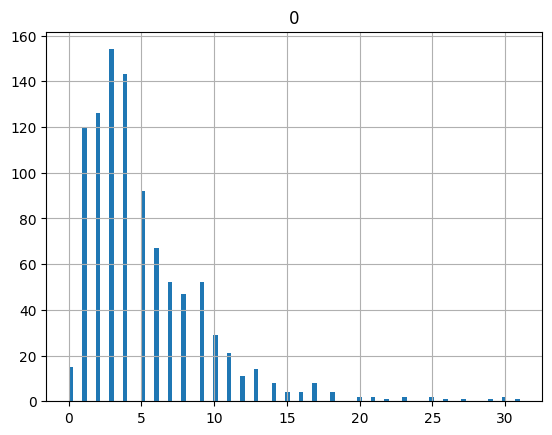

In [80]:
df.hist(bins=100)

In [156]:
emoji_removed_data

[{'section_path': 'Python Types Intro',
  'blocks': ['Python has support for optional "type hints" (also called "type annotations").',
   'These "type hints" or annotations are a special syntax that allow declaring the type of a variable.',
   'By declaring types for your variables, editors and tools can give you better support.',
   'This is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.',
   'FastAPI is all based on these type hints, they give it many advantages and benefits.',
   'But even if you never use FastAPI , you would benefit from learning a bit about them.'],
  'path': ['Python Types Intro'],
  'url': 'https://fastapi.tiangolo.com/python-types/'},
 {'section_path': 'Python Types Intro -> Motivation',
  'blocks': ["Let's start with a simple example:",
   'CODE\ndef get_full_name(first_name, last_name):\n    full_name = first_name.title() + " " + last_name.title()\n   

In [157]:
len(emoji_removed_data)

986

In [158]:
zeros = 0
for empty_block in emoji_removed_data:
    if len(empty_block['blocks']) == 0:
        zeros += 1

In [159]:
986-15

971

# Chunking

In [ ]:
## write a function, to store the chunks in this way, for the start let's suppose, if a block has zero information drop it

In [160]:
chunk_candidate = []

for candidate in emoji_removed_data:
    if len(candidate['blocks']) != 0:
        chunk_candidate.append(candidate)

In [161]:
len(chunk_candidate)

971

In [89]:
"""
{
  "content": 
    "In your editor, inside your function you will get type hints and completion everywhere (this wouldn't happen if you received a dict instead of a Pydantic model):\n\n"
    "You also get error checks for incorrect type operations:\n\n"
    "This is not by chance, the whole framework was built around that design.\n\n"
    "And it was thoroughly tested at the design phase, before any implementation, to ensure it would work with all the editors.\n\n"
    "There were even some changes to Pydantic itself to support this.\n\n"
    "The previous screenshots were taken with Visual Studio Code.\n\n"
    "But you would get the same editor support with PyCharm and most of the other Python editors.",

  "metadata": {
    "url": "https://fastapi.tiangolo.com/tutorial/body/",
    "page_title": "Request Body",
    "section_path": "Request Body -> Import Pydantic's BaseModel -> Create your data model -> Declare it as a parameter -> Results -> Automatic docs -> Editor support",
    "section_depth": 7,
    "has_code": false,
    "doc_source": "fastapi_docs"
  }
}



"""

'\n{\n  "content": \n    "In your editor, inside your function you will get type hints and completion everywhere (this wouldn\'t happen if you received a dict instead of a Pydantic model):\n\n"\n    "You also get error checks for incorrect type operations:\n\n"\n    "This is not by chance, the whole framework was built around that design.\n\n"\n    "And it was thoroughly tested at the design phase, before any implementation, to ensure it would work with all the editors.\n\n"\n    "There were even some changes to Pydantic itself to support this.\n\n"\n    "The previous screenshots were taken with Visual Studio Code.\n\n"\n    "But you would get the same editor support with PyCharm and most of the other Python editors.",\n\n  "metadata": {\n    "url": "https://fastapi.tiangolo.com/tutorial/body/",\n    "page_title": "Request Body",\n    "section_path": "Request Body -> Import Pydantic\'s BaseModel -> Create your data model -> Declare it as a parameter -> Results -> Automatic docs -> Edit

In [162]:
type(chunk_candidate)

list

In [174]:
def build_chunk(chunk_candidate):
    chunk = {
        "content": "",
        "metadata": {}
    }

    # ---- metadata (structure-derived, no loops) ----
    chunk["metadata"]["section_path"] = chunk_candidate["section_path"]
    chunk["metadata"]["section_depth"] = len(chunk_candidate["path"])
    chunk["metadata"]["page_title"] = chunk_candidate["path"][-1]
    chunk["metadata"]["has_code"] = False
    chunk['metadata']['url'] = chunk_candidate['url']

    # ---- content assembly + code detection ----
    for block in chunk_candidate["blocks"]:
        if "CODE\n" in block:
            chunk["metadata"]["has_code"] = True

        chunk["content"] += block.strip() + "\n\n"

    # final cleanup
    chunk["content"] = chunk["content"].strip()

    return chunk



In [175]:
final_chunks = []

for candidate in chunk_candidate:
    if not candidate["blocks"]:
        continue

    chunk = build_chunk(candidate)

    if not chunk["content"].strip():
        continue

    chunk["metadata"]["doc_source"] = "fastapi_docs"

    final_chunks.append(chunk)


In [182]:
import json
with open("chunks_v1.json", "w") as f:
    json.dump(final_chunks, f, indent=4)

In [184]:
from langchain_core.documents import Document

doc_lang = []

for chunks in final_chunks:
    doc = Document(
        page_content=chunks['content'],
        metadata = chunks['metadata']
    )
    doc_lang.append(doc)

In [200]:
final_chunks[0]['metadata']

{'section_path': 'Python Types Intro',
 'section_depth': 1,
 'page_title': 'Python Types Intro',
 'has_code': False,
 'url': 'https://fastapi.tiangolo.com/python-types/',
 'doc_source': 'fastapi_docs'}

In [187]:
doc_lang[0]

Document(metadata={'section_path': 'Python Types Intro', 'section_depth': 1, 'page_title': 'Python Types Intro', 'has_code': False, 'url': 'https://fastapi.tiangolo.com/python-types/', 'doc_source': 'fastapi_docs'}, page_content='Python has support for optional "type hints" (also called "type annotations").\n\nThese "type hints" or annotations are a special syntax that allow declaring the type of a variable.\n\nBy declaring types for your variables, editors and tools can give you better support.\n\nThis is just a quick tutorial / refresher about Python type hints. It covers only the minimum necessary to use them with FastAPI ... which is actually very little.\n\nFastAPI is all based on these type hints, they give it many advantages and benefits.\n\nBut even if you never use FastAPI , you would benefit from learning a bit about them.')

In [1]:
from dotenv import load_dotenv
import os
from pinecone import Pinecone
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chat_models import init_chat_model
from langchain_core.prompts import PromptTemplate

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

pc = Pinecone(api_key = PINECONE_API_KEY)

index_name = "enterprise-rag-scrape"


# create an index 
# if not pc.has_index(index_name):
#     pc.create_index(
#         name = index_name,
#         dimension=768,
#         metric="cosine",
#         spec=ServerlessSpec(
#             cloud='aws',
#             region='us-east-1'
#         )
#     )

dense_index = pc.Index(index_name)

# s4, create embeddings and upload chunks to VDB, two steps are there, iterate through each chunk, create embedding for each chunk
# and then upload it to vector database

HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") # dim = 768
        

c:\Users\amanm\Desktop\learning\rag_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [214]:
for i, chunk in enumerate(doc_lang):
    chunk_embedding = embeddings.embed_query(chunk.page_content)
    dense_index.upsert(vectors=[{"id" : str(i), "values" : chunk_embedding, "metadata" : {**chunk.metadata, 'text' :chunk.page_content } }])

In [1]:
## step 5 : chains


llm = init_chat_model(
    model='openai/gpt-oss-20b',
    model_provider='groq',

)


print(llm.invoke("Hi Are you Up?").content)




NameError: name 'init_chat_model' is not defined

In [4]:
def build_filter(query: str):
    query_lower = query.lower()

    metadata_filter = {}

    # code-focused queries
    if any(word in query_lower for word in ["code", "example", "syntax", "show", "how"]):
        metadata_filter["has_code"] = True

    # avoid very shallow sections for specific questions
    #if any(word in query_lower for word in ["why", "difference", "compare", "motivation"]):
        #metadata_filter["section_depth"] = {"$gte": 2}

    return metadata_filter if metadata_filter else None


In [13]:
def chatbot(query):
    if query.lower().strip() == "exit":
        return "Goodbye!"
    
    query_embedding = embeddings.embed_query(query)
    metadata_filter = build_filter(query)
    result = dense_index.query(
        vector=query_embedding,
        top_k=3,
        include_metadata=True,
         filter=metadata_filter

    )

    if not result.matches:
        return "I don't know."

    numbered_chunks = []
    references = {}

    # ---- create numbered context ----
    for i, match in enumerate(result.matches, start=1):
        meta = match.metadata
        text = meta.get("text")

        if not text:
            continue

        numbered_chunks.append(f"[{i}] {text}")

        references[i] = {
            "title": meta.get("page_title"),
            "url": meta.get("url"),
            "section": meta.get("section_path")
        }

    context = "\n\n".join(numbered_chunks)

    # ---- stronger prompt with citation enforcement ----
    prompt = f"""
You are an documentation expert, answering a technical documentation question.

Rules:
- You are giving answers to developers who are using the documentation for the first time
- Answer ONLY using the context
- If relevant context is not present, say "I don't know"
- Do NOT make up information
- Cite relevant info from the context itself

Context:
{context}

Question:
{query}

Answer with citations:
"""

    answer = llm.invoke(prompt).content.strip()

    # ---- format references ----
    refs = "\n".join(
        f"[{i}] {r['title']} → {r['url']}"
        for i, r in references.items()
    )

    return f"""{answer}

Sources:
{refs}
"""


In [15]:
print(chatbot("What is the use of APIRouter?"))

APIRouter is a lightweight, “mini FastAPI” class that lets you group and declare path operations separately from the main application.  
- You can define routes, dependencies, tags, responses, etc., just as you would on a FastAPI instance.  
- Once defined, the router can be included in the main FastAPI app to keep the code modular and organized.  

> *“You can think of APIRouter as a 'mini FastAPI' class. All the same options are supported. All the same parameters, responses, dependencies, tags, etc. We are going to include this APIRouter in the main FastAPI app.”*【3】

Sources:
[1] Custom Request and APIRoute class → https://fastapi.tiangolo.com/how-to/custom-request-and-route/
[2] OpenAPI Webhooks → https://fastapi.tiangolo.com/advanced/openapi-webhooks/
[3] Path operationswithAPIRouter → https://fastapi.tiangolo.com/tutorial/bigger-applications/

